In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


In [2]:
%%capture
!pip install catboost
!pip install shap

In [3]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
import os
import gc

# Params

In [4]:
original_cols = [
    'srch_id',
    #     'date_time',  # not used in models
    'site_id',
#     'visitor_location_country_id',
    'visitor_hist_starrating',
    'visitor_hist_adr_usd',
    'prop_country_id',
    'prop_id',
    'prop_starrating',
    'prop_review_score',
    'prop_brand_bool',
    'prop_location_score1',
    'prop_location_score2',
    'prop_log_historical_price',
    'price_usd',
    'promotion_flag',
    'srch_destination_id',
#     'srch_length_of_stay',
    'srch_booking_window',
#     'srch_adults_count',
    'srch_children_count',
#     'srch_room_count',
    'srch_saturday_night_bool',
    'srch_query_affinity_score',
    'orig_destination_distance',
    'random_bool',
    #     'comp1_inv',
    #     'comp1_rate_percent_diff',
    #     'comp2_inv',
    'comp2_rate_percent_diff',
    #     'comp3_inv',
    'comp3_rate_percent_diff',
    #     'comp4_inv',
    #     'comp4_rate_percent_diff',
    #     'comp5_inv',
    'comp5_rate_percent_diff',
    #     'comp6_inv',
    #     'comp6_rate_percent_diff',
    #     'comp7_inv',
    #     'comp7_rate_percent_diff',
    #     'comp8_inv',
    #     'comp8_rate_percent_diff',
]

booking_date_features = [
    'date_time_ordinal',
    #     'booking_time_minute',
    #     'booking_time_hour',
    #     'booking_time_morning',
    #     'booking_time_afternoon',
    #     'booking_time_evening',
    #     'booking_time_late_evening',
    #     'booking_time_night',
    #     'booking_time_work_hour',
    #     'booking_time_lunch',
    #     'booking_time_day',
    #     'booking_time_is_month_start',
    #     'booking_time_is_month_end',
    #     'booking_time_dow',
    #     'booking_time_is_weekend',
    #     'booking_time_doy',
    #     'booking_time_week',
    #     'booking_time_week_mid_summer_index',
    #     'booking_time_month',
    #     'booking_time_days_in_month',
    #     'booking_time_quarter',
    #     'booking_time_is_quarter_start',
    #     'booking_time_is_quarter_end',
    #     'booking_time_season_num',
    #     'booking_time_year',
    #     'booking_time_is_year_start',
    #     'booking_time_is_year_end',
    #     'booking_time_week_id',
    #     'booking_time_day_sin',
    #     'booking_time_day_cos',
    #     'booking_time_month_sin',
    #     'booking_time_month_cos',
    #     'booking_time_quarter_sin',
    #     'booking_time_quarter_cos',
    #     'booking_time_week_sin',
    #     'booking_time_week_cos',
    #     'booking_time_dow_sin',
    #     'booking_time_dow_cos',
    #     'booking_time_doy_sin',
    #     'booking_time_doy_cos',
    #     'booking_time_season_num_sin',
    #     'booking_time_season_num_cos',
#     'holidays_during_booking',
]


prop_location_score_features = [
    'prop_location_score_diff',
    #     'prop_location_score_diff_7',
    'prop_location_score_sum',
    #     'prop_location_score_sum_7',
    'prop_location_score_mul',
    'prop_location_score_diff_log',
    'prop_location_score_sum_log',
    'prop_location_score_mul_log',
]


competitor_features = [
    'higher_price_than_expedia',
#     'lower_price_than_expedia',
#     'same_price_as_expedia',
#     'comp_num_avail',
    'ratio_of_comp_with_higher_price_than_expedia',
    'ratio_of_comp_with_lower_price_than_expedia',
    #     'comp1_rate_percent_diff_signed',
    #     'comp2_rate_percent_diff_signed',
    #     'comp3_rate_percent_diff_signed',
    #     'comp4_rate_percent_diff_signed',
    'comp5_rate_percent_diff_signed',
    #     'comp6_rate_percent_diff_signed',
    #     'comp7_rate_percent_diff_signed',
    'comp8_rate_percent_diff_signed',

    #  'comp1_rate_percent_diff_log_2',
    #     'comp1_rate_percent_diff_log_10',
    #  'comp2_rate_percent_diff_log_2',
    #     'comp2_rate_percent_diff_log_10',
    #  'comp3_rate_percent_diff_log_2',
    #     'comp3_rate_percent_diff_log_10',
    #  'comp4_rate_percent_diff_log_2',
    #     'comp4_rate_percent_diff_log_10',
    #  'comp5_rate_percent_diff_log_2',
    #     'comp5_rate_percent_diff_log_10',
    #  'comp6_rate_percent_diff_log_2',
    #     'comp6_rate_percent_diff_log_10',
    #  'comp7_rate_percent_diff_log_2',
    #     'comp7_rate_percent_diff_log_10',
    #  'comp8_rate_percent_diff_log_2',
    #     'comp8_rate_percent_diff_log_10',
]

price_features = [
    'price_per_day',
#     'price_per_trip',

    #     'price_usd_pow_0.33',
#     'price_usd_pow_0.5',
#     'price_usd_pow_2',
#     'price_usd_log_2',
    'price_usd_log_10',
#     'price_usd_log_2.72',
#     'price_usd_reciprocal',

    'visitor_hist_adr_usd_pow_0.33',
    'visitor_hist_adr_usd_pow_0.5',
    'visitor_hist_adr_usd_pow_2',
    #     'visitor_hist_adr_usd_log_2',
    #     'visitor_hist_adr_usd_log_10',
    #     'visitor_hist_adr_usd_log_2.72',
    'visitor_hist_adr_usd_reciprocal',

    'prop_log_historical_price_pow_0.33',
    #     'prop_log_historical_price_pow_0.5',
    #     'prop_log_historical_price_pow_2',
#     'prop_log_historical_price_log_2',
    'prop_log_historical_price_log_10',
#     'prop_log_historical_price_log_2.72',
    'prop_log_historical_price_reciprocal',

    #     'price_per_trip_pow_0.33',
    #     'price_per_trip_pow_0.5',
    #     'price_per_trip_pow_2',
    #     'price_per_trip_log_2',
    #     'price_per_trip_log_10',
    #     'price_per_trip_log_2.72',
    #     'price_per_trip_reciprocal',

    'price_diff_to_usr_hist',
    'price_ratio_to_usr_hist',
    'price_diff_to_place_hist_price',
#     'place_hist_price_diff_usr_hist',
]


star_features = ['prop_star_usr_hist_diff',
                 'prop_review_usr_hist_diff',
                 'prop_starrating_bonus_chain',
                 'prop_star_review_sum',
                 'prop_star_review_diff',
                 'prop_star_review_min',
                 'prop_star_review_max',
                 'prop_star_review_mean', ]

price_star_features = ['price_per_star',
                       'price_per_review_score',
#                        'usr_price_per_star',
#                        'price_per_star_diff_with_usr',
#                        'price_per_review_diff_with_usr',
                       'price_per_star_log_10',
                       'price_per_review_score_log_10',
                       'usr_price_per_star_log_10',
                       ]


trip_detail_features = [
    'travel_inside',
#     'trans_ocean',
    'booking_weeks_ahead',
#     'booking_months_ahead',
    'len_of_stay_to_booking_ahead_ratio',
    #     'len_of_stay_to_booking_ahead_diff',
#     'srch_length_of_stay_in_weeks',
    #     'date',
    #     'trip_start_date',
    #     'trip_end_date',
#     'holidays_during_trip',
#     'business_trip',
    'children_per_adult',
#     'total_people',
    'people_per_room',
    'separate_children_room'
]


aggregate_features = [
    'price_index_per_srch_id',
    'price_index_per_srch_destination_id',
        'price_index_per_prop_id',
    #     'mean_click_bool_per_prop_id',
    #     'mean_booking_bool_per_prop_id',
    #     'mean_srch_query_affinity_score',
    #     'mean_position_per_prop_id',
]

uncategorized_features = [
#     'was_sold_in_that_period',
    'srch_query_affinity_score_prob'
]

##### AGGREGATION FEATURES #####
per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter = [
    #     'mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
#     'median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    #     'min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    #     'max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
#     'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter']


per_visitor_location_country_id_per_prop_id = [
    'mean_price_per_day_per_visitor_location_country_id_per_prop_id',
    'median_price_per_day_per_visitor_location_country_id_per_prop_id',
    #     'min_price_per_day_per_visitor_location_country_id_per_prop_id',
    'max_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id',

    #     'mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    #     'median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    #     'min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    #     'max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    #     'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter'
]

per_day_per_prop_id_per_trip_start_date_quarter = [
    'mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
    #     'median_price_per_day_per_prop_id_per_trip_start_date_quarter',
    #     'min_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'max_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter'
]

per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter = [
#     'mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
#     'median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
#     'min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    #     'max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter'
]

per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2 = [
    'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    #     'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    #     'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2'
]

price_per_day_per_visitor_location_country_id_per_prop_starrating = [
    'mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
#  'min_price_per_day_per_visitor_location_country_id_per_prop_starrating',
#  'max_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_starrating',
 'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_starrating'
]

per_srch_destination_id_per_srch_room_count_per_prop_review_score = [
#     'mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
#  'median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
#  'max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score',
 'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score'
]

per_day_per_srch_destination_id_per_trip_start_date_quarter = [
#     'mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
#  'median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
#  'min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
#  'max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
#  'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter',
 'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter'
]

per_day_per_prop_country_id = [
#     'mean_price_per_day_per_prop_country_id',
#  'median_price_per_day_per_prop_country_id',
 'min_price_per_day_per_prop_country_id',
 'max_price_per_day_per_prop_country_id',
#  'price_per_day_diff_to_mean_price_per_day_per_prop_country_id',
#  'price_per_day_rel_diff_to_mean_price_per_day_per_prop_country_id',
 'price_per_day_diff_to_median_price_per_day_per_prop_country_id',
 'price_per_day_rel_diff_to_median_price_per_day_per_prop_country_id',
 'price_per_day_diff_to_min_price_per_day_per_prop_country_id',
 'price_per_day_rel_diff_to_min_price_per_day_per_prop_country_id',
 'price_per_day_diff_to_max_price_per_day_per_prop_country_id',
 'price_per_day_rel_diff_to_max_price_per_day_per_prop_country_id'
]

per_visitor_location_country_id_per_prop_review_score = [
    'mean_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'median_price_per_day_per_visitor_location_country_id_per_prop_review_score',
#  'min_price_per_day_per_visitor_location_country_id_per_prop_review_score',
#  'max_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_review_score',
#  'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_review_score',
 'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_review_score',
#  'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_review_score'
]

per_visitor_location_country_id_per_srch_destination_id = [
    'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
#  'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
#  'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
#  'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id',
 'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id'
]

per_prop_id = [
    'mean_price_per_day_per_prop_id',
 'median_price_per_day_per_prop_id',
 'min_price_per_day_per_prop_id',
 'max_price_per_day_per_prop_id',
 'price_per_day_diff_to_mean_price_per_day_per_prop_id',
 'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id',
 'price_per_day_diff_to_median_price_per_day_per_prop_id',
 'price_per_day_rel_diff_to_median_price_per_day_per_prop_id',
 'price_per_day_diff_to_min_price_per_day_per_prop_id',
 'price_per_day_rel_diff_to_min_price_per_day_per_prop_id',
 'price_per_day_diff_to_max_price_per_day_per_prop_id',
 'price_per_day_rel_diff_to_max_price_per_day_per_prop_id'
]

per_day_per_srch_destination_id_per_prop_review_score = [
#     'mean_price_per_day_per_srch_destination_id_per_prop_review_score',
#  'median_price_per_day_per_srch_destination_id_per_prop_review_score',
 'min_price_per_day_per_srch_destination_id_per_prop_review_score',
 'max_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_prop_review_score',
#  'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_prop_review_score',
 'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_prop_review_score'
]

cols_to_use = (original_cols + booking_date_features + prop_location_score_features +
               competitor_features + price_features +
               trip_detail_features + aggregate_features + uncategorized_features +
               star_features + price_star_features +
               
               per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter +
               per_visitor_location_country_id_per_prop_id +
               per_day_per_prop_id_per_trip_start_date_quarter +
               per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter +
#                per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2 +
               price_per_day_per_visitor_location_country_id_per_prop_starrating + 
               per_srch_destination_id_per_srch_room_count_per_prop_review_score +
              per_day_per_srch_destination_id_per_trip_start_date_quarter +
              per_day_per_prop_country_id +
              per_visitor_location_country_id_per_prop_review_score + 
              per_visitor_location_country_id_per_srch_destination_id + 
              per_prop_id +
              per_day_per_srch_destination_id_per_prop_review_score)

len(cols_to_use)

186

In [5]:
assert len(cols_to_use) == len(set(cols_to_use)), 'some columns are duplicated'

In [6]:
CAT_FEATURES = ['srch_id',
                'site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id',
                'week_id',
                'season_num', 'day', 'month', 'year', 'quarter', 'week', 'dow'
                ]

CAT_FEATURES = [c for c in CAT_FEATURES if c in cols_to_use]

# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

# drop_cols = ['usr_extra_pay']

group_col = 'srch_id'
predict_item_col = 'prop_id'

DROP_DATETIME_TYPE = True

# Read data

In [7]:
data_path = 'data' # '../input/expedia-with-aggregated-features-15-may' 

In [8]:
# # 15.05.2022 Oleg: for feature listing purposes. Do not used in modeling

# val_df = pd.read_feather(os.path.join(data_path, 'X_val.feather'))

# cols = val_df.columns.to_list()
# cols = [c for c in cols if 'per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_day_per_visitor_location_country_id_per_prop_id' not in c]
# cols = [c for c in cols if 'per_day_per_prop_id_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2' not in c]
# cols = [c for c in cols if 'price_per_day_per_visitor_location_country_id_per_prop_starrating' not in c]
# cols = [c for c in cols if 'per_srch_destination_id_per_srch_room_count_per_prop_review_score' not in c]
# cols = [c for c in cols if not c.endswith('per_day_per_srch_destination_id_per_trip_start_date_quarter')]
# cols = [c for c in cols if not c.endswith('per_day_per_prop_country_id')]
# cols = [c for c in cols if not c.endswith('per_visitor_location_country_id_per_prop_review_score')]
# cols = [c for c in cols if not c.endswith('per_visitor_location_country_id_per_srch_destination_id')]
# cols = [c for c in cols if not c.endswith('per_prop_id')]
# cols = [c for c in cols if 'per_day_per_srch_destination_id_per_prop_review_score' not in c]
# print(len(cols))
# [c for c in cols if 'per_day_per_srch_destination_id_per_prop_review_score' in c]
# # [c for c in cols if c.endswith('per_prop_id')]
# # sorted([c for c in cols if c not in cols_to_use and 'per_srch_destination_id' in c][100:])



In [9]:
X_train = pd.read_feather(os.path.join(data_path, 'X_train.feather'), columns=cols_to_use)
y_train = pd.read_feather(os.path.join(data_path, 'y_train.feather'))['target']
print('X_train.shape', X_train.shape)
X_train.head()

X_train.shape (3969251, 186)


,srch_id,site_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_booking_window,srch_children_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp2_rate_percent_diff,comp3_rate_percent_diff,comp5_rate_percent_diff,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,higher_price_than_expedia,ratio_of_comp_with_higher_price_than_expedia,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day,price_usd_log_10,visitor_hist_adr_usd_pow_0.33,visitor_hist_adr_usd_pow_0.5,visitor_hist_adr_usd_pow_2,visitor_hist_adr_usd_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,travel_inside,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,children_per_adult,people_per_room,separate_children_room,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,usr_price_per_star_log_10,price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,mean_price_per_day_per_visitor_location_country_id_per_prop_id,median_price_per_day_per_visitor_location_country_id_per_prop_id,max_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,price_per_day_diff_to_max_price_per_day_per_visitor_

In [10]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [11]:
X_train.memory_usage().sum() / 1024**2

2680.044017791748

In [12]:
# # makes sure all features are categorized
# assert set() == set(X_train.columns) - set(original_cols + booking_date_features + prop_location_score_features + competitor_features + price_features + historical_price_features + trip_detail_features + aggregate_features + uncategorized_features)

In [13]:
X_train.dtypes.value_counts()#.apply(lambda x: x.name).to_dict()

float32    169
uint8        8
uint32       4
uint16       3
bool         2
dtype: int64

In [14]:
train_pool = Pool(data=X_train, 
                  label=y_train,
                  group_id=X_train[group_col],
                  cat_features=CAT_FEATURES,
                  )
del X_train, y_train; gc.collect()

45

In [15]:
X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'), columns=cols_to_use)
y_val = pd.read_feather(os.path.join(data_path, 'y_val.feather'))['target']    
print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

del X_val, y_val; gc.collect()

X_val.shape (496664, 186)


0

# Fit final model

In [17]:
import catboost
catboost.__version__

'1.0.5'

In [18]:
gc.collect()

46

In [19]:
params = {
    "iterations": 5000, # make 1500
    'loss_function': 'YetiRankPairwise', # YetiRank should be faster # hints=skip_train~false
#     'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition;hints=skip_train~false'], # :
    "verbose": False,
    'early_stopping_rounds': 400,
    'use_best_model': True,
#     'metric_period': 50,
    "task_type": "GPU",
}

In [20]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=False, verbose_eval=True)

Groupwise loss function. OneHotMaxSize set to 10


Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4250443	best: 0.4250443 (0)	total: 437ms	remaining: 36m 23s
1:	test: 0.4316487	best: 0.4316487 (1)	total: 843ms	remaining: 35m 7s
2:	test: 0.4585229	best: 0.4585229 (2)	total: 1.25s	remaining: 34m 42s
3:	test: 0.4623071	best: 0.4623071 (3)	total: 1.71s	remaining: 35m 36s
4:	test: 0.4653386	best: 0.4653386 (4)	total: 2.23s	remaining: 37m 7s
5:	test: 0.4729516	best: 0.4729516 (5)	total: 2.64s	remaining: 36m 37s
6:	test: 0.4751401	best: 0.4751401 (6)	total: 3.05s	remaining: 36m 13s
7:	test: 0.4789811	best: 0.4789811 (7)	total: 3.45s	remaining: 35m 53s
8:	test: 0.4829658	best: 0.4829658 (8)	total: 3.85s	remaining: 35m 36s
9:	test: 0.4831646	best: 0.4831646 (9)	total: 4.26s	remaining: 35m 25s
10:	test: 0.4848427	best: 0.4848427 (10)	total: 4.66s	remaining: 35m 13s
11:	test: 0.4857721	best: 0.4857721 (11)	total: 5.07s	remaining: 35m 5s
12:	test: 0.4871391	best: 0.4871391 (12)	total: 5.47s	remaining: 34m 59s
13:	test: 0.4884316	best: 0.4884316 (13)	total: 5.87s	remaining: 34m 52s
1

In [21]:
model.save_model('catboost_model')

In [ ]:
from IPython.display import FileLink
FileLink(r'catboost_model')

In [22]:
!zip -r catboost_info.zip /kaggle/working/catboost_info/

  adding: kaggle/working/catboost_info/ (stored 0%)
  adding: kaggle/working/catboost_info/learn/ (stored 0%)
  adding: kaggle/working/catboost_info/learn/events.out.tfevents (stored 0%)
  adding: kaggle/working/catboost_info/test_error.tsv (deflated 60%)
  adding: kaggle/working/catboost_info/test/ (stored 0%)
  adding: kaggle/working/catboost_info/test/events.out.tfevents (deflated 81%)
  adding: kaggle/working/catboost_info/learn_error.tsv (stored 0%)
  adding: kaggle/working/catboost_info/catboost_training.json (deflated 78%)
  adding: kaggle/working/catboost_info/tmp/ (stored 0%)
  adding: kaggle/working/catboost_info/time_left.tsv (deflated 53%)


# Eval

In [16]:
# I run this locally as don't have enough capacity to train
model = CatBoostRanker()
model.load_model('trained_models/catboost_model', format='cbm')

In [ ]:
# from catboost.utils import eval_metric
# In ranking tasks it is not necessary to predict the same labels.
# It is important to predict the right order of objects.
# eval_metric(labels, good_predictions, 'NDCG:top=5;type=Base;denominator=LogPosition', 
#             group_id=group_ids)

In [23]:
print(model.eval_metrics(val_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))
del val_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.40284091610282924]}


115

In [24]:
print(model.eval_metrics(train_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))

del train_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.44847440164585095]}


23

In [26]:
X_test = pd.read_feather(os.path.join(data_path, 'X_test.feather'), columns=cols_to_use)
y_test = pd.read_feather(os.path.join(data_path, 'y_test.feather'))['target']

print('X_test.shape', X_test.shape)

test_pool = Pool(data=X_test,
                label=y_test,
                group_id=X_test[group_col],
                cat_features=CAT_FEATURES,
                )

print(model.eval_metrics(test_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))

del X_test, y_test, test_pool; gc.collect()

X_test.shape (492432, 186)
{'NDCG:top=5;type=Base': [0.39971940980809656]}


0

# Retrain the model on train+val, with test set as eval. The hyper parameters are frozen!  

Uncomment at the end of the competition

In [ ]:
# train_val_pool = Pool(data=pd.concat([X_train, X_val], axis=0),
#                       label=data=pd.concat([y_train, y_val], axis=0),
#                       group_id=pd.concat([X_train, X_val], axis=0)[group_col],
#                       cat_features=CAT_FEATURES,
#                       )

In [ ]:
# params["iterations"] += 1000

# model = CatBoostRanker(**params)
# model.fit(train_val_pool, eval_set=test_pool, plot=False, verbose_eval=True)

# Make preds

In [17]:
def predict_in_format(model, data, pool, group_col, predict_item_col, gt_col=None):
    preds = model.predict(pool)

    values = {group_col: data[group_col],
              predict_item_col: data[predict_item_col],
              'pred': preds}

    values_df = pd.DataFrame(values)
    values_df.sort_values(by=[group_col, 'pred'], ascending=[True, False], inplace=True)

    if gt_col is not None:
        values_df['gt'] = gt_col
        ndcg_score = values_df.groupby(group_col)['gt'].apply(ndcg, at=5).mean()
        print('Local test NDCG@5:', ndcg_score)

    return values_df

In [18]:
subm_df = pd.read_feather(os.path.join(data_path, 'submission_df_preprocessed.feather'), columns=cols_to_use)
subm_df.sort_values([group_col], inplace=True)

In [19]:
subm_name = 'submissions/submission_16.csv'

In [20]:
subm_pool = Pool(
    data=subm_df,
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

output_df = predict_in_format(model, subm_df, subm_pool, group_col, predict_item_col)
del subm_df, subm_pool; gc.collect()
output_df.head(10)

,srch_id,prop_id,pred
23,1,99484,2.683593
9,1,54937,2.499509
12,1,61934,2.160355
5,1,28181,2.136857
22,1,95031,2.006265
4,1,24194,1.841240
6,1,34263,1.745767
18,1,82231,1.721430
8,1,50162,1.613495
1,1,5543,1.604730


In [21]:
output_df[[group_col, 'prop_id']].to_csv(subm_name, index=False)
del output_df; gc.collect()
pd.read_csv(subm_name, nrows=10)

,srch_id,prop_id
0,1,99484
1,1,54937
2,1,61934
3,1,28181
4,1,95031
5,1,24194
6,1,34263
7,1,82231
8,1,50162
9,1,5543


In [24]:
# use locally or if you added the sample subm file to the dataset
def validate_submission(subm_sample_path, our_subm_path):
    
    subm_sample = pd.read_csv(subm_sample_path)
    our_subm = pd.read_csv(our_subm_path)
    
    assert subm_sample.shape == our_subm.shape
    assert our_subm[group_col].equals(subm_sample[group_col])
    assert our_subm.index.equals(subm_sample.index)
    assert subm_sample.groupby(group_col)['prop_id'].apply(len).to_frame().equals(
        our_subm.groupby(group_col)['prop_id'].apply(len).to_frame())
    print('everything is ok to submit')
    
validate_submission(os.path.join(data_path, 'submission_sample.csv'),
                    subm_name)

everything is ok to submit


Score: 0.40694

# Feature importance

In [22]:
# del test_pool; gc.collect()

X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'), columns=cols_to_use).sample(100000)
X_val = X_val[X_val.index.isin((X_val[group_col].value_counts() > 1).index)]
X_val.sort_values(group_col, inplace=True)
y_val = pd.read_feather(os.path.join(data_path, 'y_val.feather')).loc[X_val.index, 'target']
print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

X_val.shape (3892, 186)


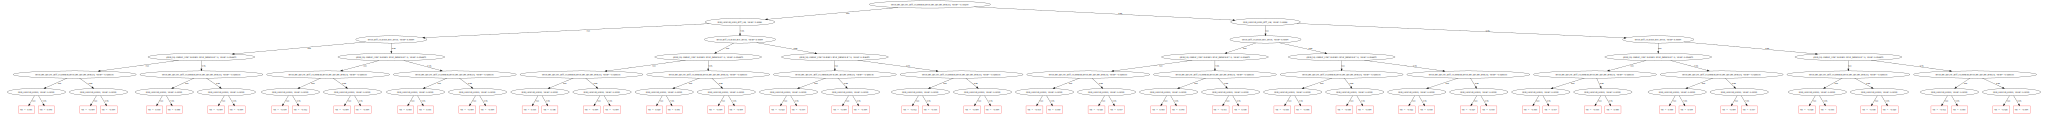

In [28]:
g = model.plot_tree(
    tree_idx=0,
    pool=val_pool
)
g

In [30]:
# g.save('tree.pdf')

In [ ]:
# from feature_importance import get_and_plot_feature_imp_catboost

# COLLECT_N_IMPORTANT_FEATURES = 150

# feature_score_SHAP, shap_values_raw = get_and_plot_feature_imp_catboost(model, X_val, y_val,
#                                                                         method='SHAP',
#                                                                         cat_features=CAT_FEATURES,
#                                                                         #                                                        plot_type='bar',
#                                                                         top_n=COLLECT_N_IMPORTANT_FEATURES)

# # important_features_collected.update(feature_score_SHAP.sort_values(
# #     ['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

In [ ]:
# pd.set_option('max_rows', None)
# feature_score_SHAP.sort_values('Score', ascending=False)

# shap_values_raw

features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [31]:
import shap
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(val_pool) # X_val

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

In [33]:
pd.set_option('max_rows', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
features = X_val.columns
mean_shaps = np.abs(shap_values.values).mean(0)
# mask = mean_shaps.argsort()[::-1]
# features[mask]
shaps_df = pd.DataFrame({'feature': features, 'shap': mean_shaps})
shaps_df[shaps_df['feature'].isin(cols_to_use)].sort_values('shap', ascending=True)

,feature,shap
70,usr_price_per_star_log_10,0.000556
39,visitor_hist_adr_usd_pow_0.5,0.000628
41,visitor_hist_adr_usd_reciprocal,0.000728
3,visitor_hist_adr_usd,0.000736
36,price_per_day,0.000749
38,visitor_hist_adr_usd_pow_0.33,0.000773
31,higher_price_than_expedia,0.000837
75,price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,0.001098
23,comp5_rate_percent_diff,0.001108
137,price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_trip_start_date_quarter,0.001113


In [34]:
shaps_df['per_col'] = shaps_df['feature'].apply(lambda x: ''.join(x.split('per_')[1:]))
shaps_df[shaps_df['per_col'] != ''].sort_values(['per_col', 'shap']).drop(['per_col'], axis=1)

,feature,shap
51,children_per_adult,0.014380
36,price_per_day,0.000749
146,price_per_day_diff_to_max_price_per_day_per_prop_country_id,0.129052
175,price_per_day_diff_to_max_price_per_day_per_prop_id,0.017293
112,price_per_day_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter,0.001576
104,price_per_day_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter,0.004321
184,price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_prop_review_score,0.006013
131,price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_prop_review_score,0.004271
138,price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_trip_start_date_quarter,0.011002
87,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id,0.002358


TypeError: 'Pool' object is not subscriptable

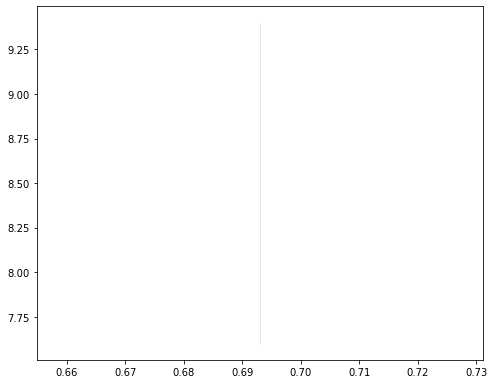

In [35]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[1])

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.force(shap_values[10])

In [ ]:
# visualize all the training set predictions
shap.plots.force(shap_values[:100])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion at a single value represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. 

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:100, "prop_location_score2"], color=shap_values[:100])

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=100)

In [ ]:
shap.plots.bar(shap_values, max_display=100)

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with shap.TreeExplainer(model).shap_interaction_values(X). This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships

https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

In [ ]:
# explainer.shap_interaction_values(X_val.head(10))

In [ ]:
# feature_score_PredictionValuesChange = get_and_plot_feature_imp_catboost(
#         model, X_val, y_val,
#         cat_features=CAT_FEATURES,
#         method='PredictionValuesChange',
#         top_n=COLLECT_N_IMPORTANT_FEATURES)

#     important_features_collected.update(feature_score_PredictionValuesChange.sort_values(['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

For each feature, LossFunctionChange represents the difference between the loss value of the model with this feature and without it.

+ more accurate than Prediction Values Change
+ more fast than Shap Values
- assumes that loss function changes for several features can be summed up

In [ ]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange']:
    fi = model.get_feature_importance(val_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_val.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

In [ ]:
feature_score.sort_values('Feature')

In [ ]:
feature_score['per_col'] = feature_score['Feature'].apply(lambda x: ''.join(x.split('per_')[1:]))
feature_score[feature_score['per_col'] != ''].sort_values('per_col').drop(['per_col'], axis=1)